<a href="https://colab.research.google.com/github/Gehlen05/sms-classifier-senior-sistemas/blob/main/sms_classifier_rede_neural_token_senior_sistemas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importacoes

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn import metrics
from ast import increment_lineno
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


### Leitura arquivo
Projeto foi montado para rodar no colab, podendo ser rodado em outras interfaces. Porem deve se atentar aos diretorios. Para o projeto executar corretamente o arquivo sms_senior.csv devera estar na pasta do drive Colab Notebooks junto com o projeto. Caso opte por rodar na maquina no jupyter devera ser mudado o caminho.

In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sms_senior.csv',  encoding= 'unicode_escape', delimiter=',')
df.head()

Mounted at /content/drive


,Full_Text,got,great,wat,free,text,txt,win,already,dun,...,number,wish,leave,thing,many,wan,Common_Word_Count,Word_Count,Date,IsSpam
0,Hey! Congrats 2u2. id luv 2 but ive had 2 go h...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,12,2017-01-01 00:08:00,no
1,"came to look at the flat, seems ok, in his 50s...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,23,2017-01-01 00:19:00,no
2,Urgent! call 09061749602 from Landline. Your c...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,25,2017-01-01 01:53:00,yes
3,Do you hide anythiing or keeping distance from me,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,9,2017-01-01 02:14:00,no
4,"Actually, my mobile is full of msg. And i m do...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,9,29,2017-01-01 02:25:00,no


### Mapa
Mapa de distribuicao de Comun e Spam.

no     4827
yes     747
Name: IsSpam, dtype: int64


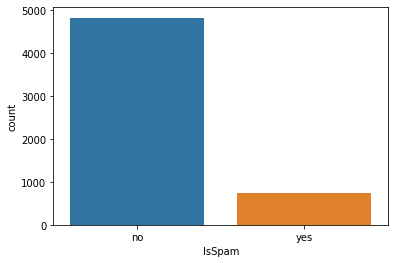

In [3]:
ax = sns.countplot(x='IsSpam',data=df)
print(df['IsSpam'].value_counts())

Mapa de calor entre as colunas.

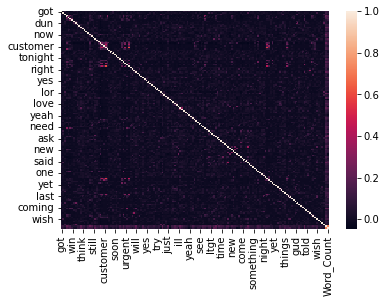

In [4]:
f, ax = plt.subplots()
sns.heatmap(df.corr());

### Separacao e normalizacao
O campo Date foi seprado e transformado em string.

In [5]:
df['scaled_date'] = pd.to_datetime(df['Date'])
df['scaled_time'] = pd.to_datetime(df['Date'])
df['scaled_date'] = df['scaled_date'].dt.strftime('%Y%m%d')
df['scaled_time'] =  df['scaled_time'].dt.strftime('%H%M%s')

Colunas foram normalizadas para nao ter discrepancia de valores.

In [6]:
rob_scaler = RobustScaler()
df['scaled_time'] = rob_scaler.fit_transform(df['scaled_time'].values.reshape(-1,1))
df['scaled_date'] = rob_scaler.fit_transform(df['scaled_date'].values.reshape(-1,1))
df['Common_Word_Count'] = rob_scaler.fit_transform(df['Common_Word_Count'].values.reshape(-1,1))
df['Word_Count'] = rob_scaler.fit_transform(df['Word_Count'].values.reshape(-1,1))
df.loc[df.IsSpam=='no','IsSpam']='0'
df.loc[df.IsSpam=='yes','IsSpam']='1'

### Tokenizacao e concatenacao
Na sequencia foi tokenizado o campo Full_Text do arquivo de entrada

In [7]:
vectorizer = CountVectorizer()
df_countvectorizer = vectorizer.fit_transform(df['Full_Text'])

In [8]:
df_countvectorizer.shape

(5574, 8720)

In [9]:
df_full_text = pd.DataFrame(df_countvectorizer.toarray())

In [10]:
df_full_text = pd.DataFrame(df_countvectorizer.toarray())

In [11]:
df_full_text.head()

,0,1,2,3,4,5,6,7,8,9,...,8710,8711,8712,8713,8714,8715,8716,8717,8718,8719
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
df.insert(1, 'date_norm', df['scaled_date'])
df.insert(2, 'time_norm', df['scaled_time'])

In [13]:
df.drop(['time', 'scaled_date', 'scaled_time', 'Date', 'Full_Text'], axis=1, inplace=True)

Concatenando o df de entrad ja modificado e o df gerado a partir da tokenizacao

In [14]:
df = pd.concat([df_full_text, df], axis = 1)

In [15]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,phone,number,wish,leave,thing,many,wan,Common_Word_Count,Word_Count,IsSpam
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.333333,-0.0625,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.333333,0.6250,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.666667,0.7500,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-0.666667,-0.2500,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2.333333,1.0000,0


### Separando entrada e saida para os modelos

In [16]:
x = df.iloc[:, 1:-1].values
y = df.iloc[:, -1].values

Dividindo a entrada e saida em treino e teste

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [18]:
x_train.shape

(4459, 8871)

### Rede Neural
 Após dois modelos de machine learning, foi implementado uma rede neural com 3 camadas com 152 neuronio e uma saída.

In [19]:
classifier = tf.keras.models.Sequential()
classifier.add(tf.keras.layers.Dense(units = 152, activation='relu', input_shape=(8871,)))
classifier.add(tf.keras.layers.Dense(units = 152, activation='relu'))
classifier.add(tf.keras.layers.Dense(units = 152, activation='relu'))
classifier.add(tf.keras.layers.Dense(units = 1, activation='sigmoid'))

Para erro foi utilizado o entropia binaria pois a saída é 0 ou 1.

In [20]:
classifier.compile(optimizer='Adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [21]:
y_train = y_train.astype(int)

A quantidade de epocas escolhida 3 pois é possível ver o joelho no segundo treinamento.

In [22]:
epochs_hist = classifier.fit(x_train, y_train, batch_size = 32, epochs=3)

Epoch 1/3
140/140 [==============================] - 3s 13ms/step - loss: 0.1481 - accuracy: 0.9504
Epoch 2/3
140/140 [==============================] - 2s 13ms/step - loss: 0.0101 - accuracy: 0.9975
Epoch 3/3
140/140 [==============================] - 2s 13ms/step - loss: 0.0021 - accuracy: 0.9996


In [23]:
y_pred_test = classifier.predict(x_test)

35/35 [==============================] - 0s 5ms/step


Matriz confusao resultou:

TP: 968 classificados corretamente como sms comun

FN: 2 classificados incoretamente como sms spam

FP: 13 classificados incorretamente como sms comun

TN: 132 classificados coretamente como sms spam


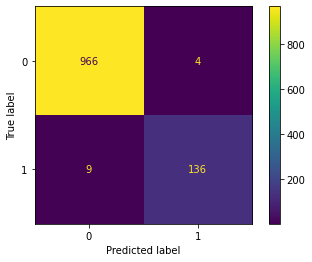

In [24]:
y_test = y_test.astype(int)
y_pred_test = (y_pred_test>0.5)
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [29]:
print('Acurácia: ', metrics.accuracy_score(y_test, y_pred_test))
print('Precisão: ', metrics.precision_score(y_test, y_pred_test))
print('Recall: ', metrics.recall_score(y_test, y_pred_test))
print('F1: ', metrics.f1_score(y_test, y_pred_test))

Acurácia:  0.9883408071748879
Precisão:  0.9714285714285714
Recall:  0.9379310344827586
F1:  0.9543859649122807


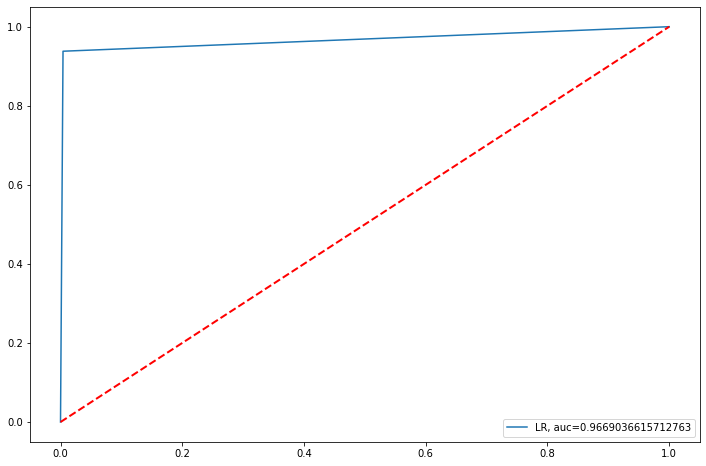

In [26]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_test)
auc = metrics.roc_auc_score(y_test, y_pred_test)

plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr, tpr, label ="LR, auc="+str(auc))
plt.plot([0,1], [0,1], color='red', lw=2, linestyle ='--')
plt.legend(loc=4)

Text(0, 0.5, 'Treino accuracia')

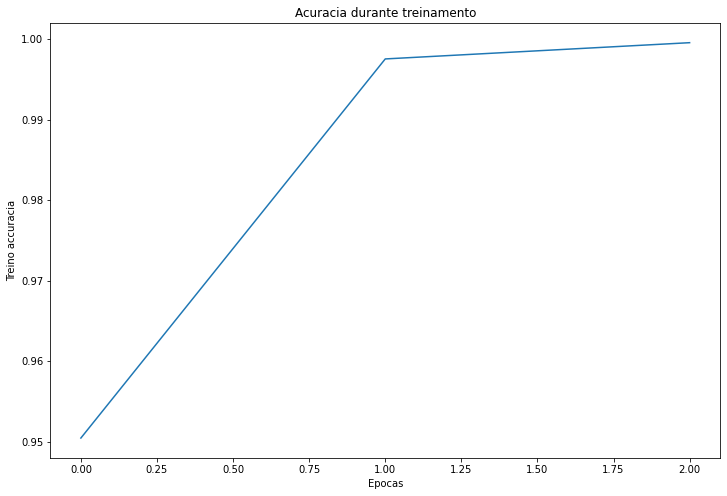

In [27]:
plt.plot(epochs_hist.history['accuracy'])
plt.title('Acuracia durante treinamento')
plt.xlabel('Epocas')
plt.ylabel('Treino accuracia')
# plt.legend(['Training accuracy'])

Text(0, 0.5, 'Treino erro')

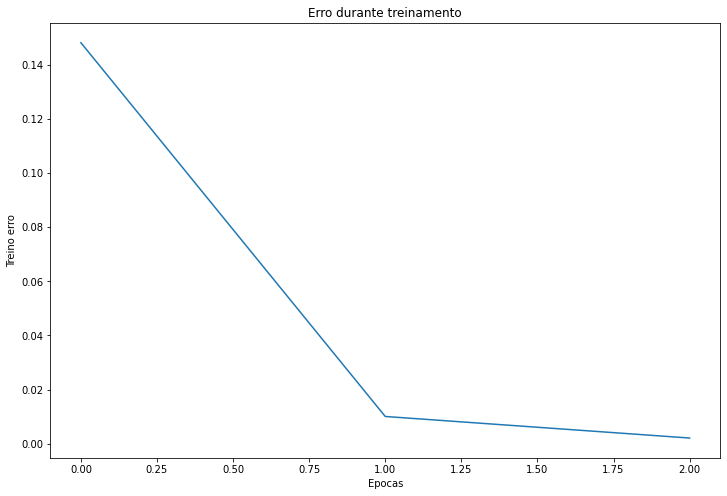

In [28]:
plt.plot(epochs_hist.history['loss'])
plt.title('Erro durante treinamento')
plt.xlabel('Epocas')
plt.ylabel('Treino erro')